In [1]:
import glob
import pandas as pd
cat = glob.glob("train/train/cat.*.jpg")
dog = glob.glob("train/train/dog.*.jpg")
data = pd.DataFrame({
    "path":cat + dog,
    "ans":[0] * len(cat) + [1] * len(dog)
})
data

,path,ans
0,train/train\cat.0.jpg,0
1,train/train\cat.1.jpg,0
2,train/train\cat.10.jpg,0
3,train/train\cat.100.jpg,0
4,train/train\cat.1000.jpg,0
...,...,...
24995,train/train\dog.9995.jpg,1
24996,train/train\dog.9996.jpg,1
24997,train/train\dog.9997.jpg,1
24998,train/train\dog.9998.jpg,1


In [2]:
from keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

Using TensorFlow backend.
C:\Users\Java\PycharmProjects\DemoDB103\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Java\PycharmProjects\DemoDB103\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Java\PycharmProjects\DemoDB103\venv\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Java\Pychar

C:\Users\Java\PycharmProjects\DemoDB103\venv\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Java\PycharmProjects\DemoDB103\venv\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Java\PycharmProjects\DemoDB103\venv\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Java\PycharmProj



Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [3]:
from keras.layers import Flatten, Dense, Dropout
from keras.layers import BatchNormalization
from keras.models import Model
# Dense(256, activation="relu") -> 函式(e.g. return print)
# tensor = func(tensor)
for l in vgg.layers:
    l.trainable = False
# 1024:trainable 1024:non-trainable
x = BatchNormalization()(vgg.output)
x = Flatten()(x)
x = Dense(2048, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(2, activation="softmax")(x)
# Model(inputs=tensor, outputs=tensor)
cnn = Model(inputs=vgg.input, outputs=x)
cnn.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________

In [4]:
# trainable一定要在compile前就設定
cnn.compile(loss="categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])

In [5]:
from sklearn.model_selection import train_test_split
# !!! 進入訓練階段以後, list(X), dataframe(X) np.array(O)
import numpy as np
from keras.utils.np_utils import to_categorical
x = np.array(data["path"])
y = np.array(data["ans"])
y_cat = to_categorical(y)
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y_cat, 
                                                    test_size=0.1)

In [6]:
# Pillow(PIL)
# 處理一張照片給你看
from keras.preprocessing.image import load_img
# 一定使用那個模型的preprocess
from keras.applications.vgg16 import preprocess_input
img = load_img(x_train[0], target_size=(224, 224)).convert("RGB")
img_np = np.array(img)
preprocess_input(img_np)

array([[[-103.939   ,  -93.779   ,  -92.68    ],
        [-103.939   , -100.779   ,  -99.68    ],
        [-100.939   ,  -92.779   ,  -91.68    ],
        ...,
        [ -86.939   ,  -90.779   ,  -84.68    ],
        [ -83.939   ,  -87.779   ,  -84.68    ],
        [ -78.939   ,  -82.779   ,  -79.68    ]],

       [[ -76.939   ,  -68.779   ,  -67.68    ],
        [ -67.939   ,  -59.779   ,  -58.68    ],
        [ -69.939   ,  -61.779   ,  -60.68    ],
        ...,
        [ -46.939003,  -50.779   ,  -44.68    ],
        [ -47.939003,  -51.779   ,  -48.68    ],
        [ -52.939003,  -56.779   ,  -53.68    ]],

       [[ -93.939   ,  -85.779   ,  -84.68    ],
        [-103.939   ,  -99.779   ,  -98.68    ],
        [ -97.939   ,  -91.779   ,  -90.68    ],
        ...,
        [-103.939   , -108.779   , -102.68    ],
        [-103.939   , -109.779   , -106.68    ],
        [-103.939   , -113.779   , -110.68    ]],

       ...,

       [[  48.060997,   38.221   ,   22.32    ],
        [  

In [7]:
# x:圖片, y:答案, batch:取幾個
# 回傳 (原始圖片[batch], 處理圖片[batch], 答案[batch])
def get_data(x, y, batch):
    idx = np.random.randint(0, x.shape[0], batch)
    # 原本未處理的圖片
    oriimgs = []
    # Preprocess過後的圖片
    preimgs = []
    for p in x[idx]:
        img = load_img(p, target_size=(224, 224)).convert("RGB")
        img_np = np.array(img)
        oriimgs.append(img_np)
        img_pre = preprocess_input(img_np) 
        preimgs.append(img_pre)

    oriimgs = np.array(oriimgs)
    preimgs = np.array(preimgs)
    ans = y[idx]
    return (oriimgs, preimgs, ans)

In [11]:
# 訓練: train_on_batch
# 驗證: test_on_batch
for i in range(10):
    print("次數:", i + 1)
    batch = 10
    train = get_data(x_train, y_train, batch)
    train_result = cnn.train_on_batch(train[1], train[2])
    print("[Train]:", train_result)
    # 如果可以把驗證的圖片設多一點
    test_batch = 20
    test = get_data(x_test, y_test, test_batch)
    test_result = cnn.test_on_batch(test[1], test[2])
    print("[Validate]:", test_result)
    print("-" * 30)

次數: 1
[Train]: [1.6118095, 0.9]
[Validate]: [1.3390129, 0.9]
------------------------------
次數: 2
[Train]: [1.6118101, 0.9]
[Validate]: [3.2285228, 0.8]
------------------------------
次數: 3
[Train]: [7.129943, 0.5]
[Validate]: [1.6118095, 0.9]
------------------------------
次數: 4
[Train]: [1.6118095, 0.9]
[Validate]: [2.079553, 0.8]
------------------------------
次數: 5
[Train]: [1.1920929e-07, 1.0]
[Validate]: [3.7654567, 0.7]
------------------------------
次數: 6
[Train]: [2.8016868, 0.8]
[Validate]: [2.865919, 0.8]
------------------------------
次數: 7
[Train]: [1.1348524, 0.9]
[Validate]: [2.3937068, 0.85]
------------------------------
次數: 8
[Train]: [1.6118095, 0.9]
[Validate]: [4.029524, 0.75]
------------------------------
次數: 9
[Train]: [1.1920929e-07, 1.0]
[Validate]: [2.4177144, 0.85]
------------------------------
次數: 10
[Train]: [3.2237232, 0.8]
[Validate]: [0.80590475, 0.95]
------------------------------


In [12]:
# 秀一下問題給你看
# 問題1: 怎麼全部同一個預測
# 問題2: 機率不該看到1 & 0
cnn.predict(test[1])

array([[1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [5.5201178e-33, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 1.4441632e-24],
       [8.7384160e-29, 1.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 5.5466224e-28],
       [1.1042269e-27, 1.0000000e+00]], dtype=float32)

In [14]:
final_batch = 200
final = get_data(x_test, y_test, final_batch)
pre = cnn.predict(final[1])
cnn.evaluate(final[1], final[2])

200/200 [==============================] - 20s 98ms/step


[2.2879593005171044, 0.85]

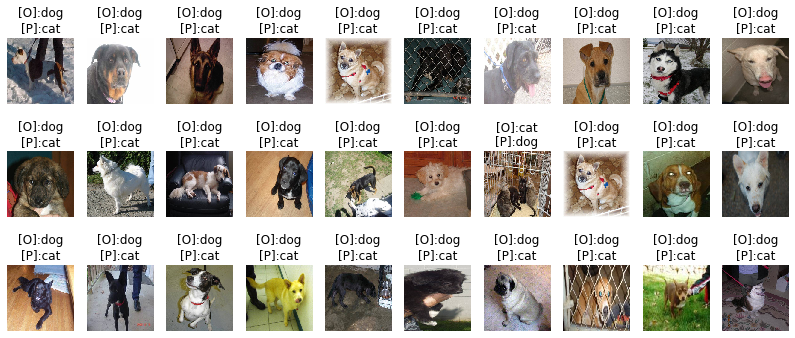

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
# Model沒有predict_classes
# 所以我們要用argmax() 取得最大值的索引
# pre.argmax(axis=1)
idx = np.nonzero(pre.argmax(axis=1) != final[2].argmax(axis=1))[0]
# 預測錯誤的圖片
false_img = final[0][idx]
# 預測錯誤圖片的正確答案
false_answer = final[2].argmax(axis=1)[idx]
# 預測錯誤圖片的預測標籤
false_pre = pre.argmax(axis=1)[idx]

trans = ["cat", "dog"]
width = 10
height = len(false_img) // width + 1
plt.figure(figsize=(14, 8))
for i,img in enumerate(false_img):
    plt.subplot(height, width, i+1)
    t = "[O]:" + trans[false_answer[i]] + "\n[P]:" + trans[false_pre[i]]
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)
